<a href="https://colab.research.google.com/github/fuyan2/ML_research/blob/master/simple_gan_2clusters_distorted_aux.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instructions for updating:
Colocations handled automatically by placer.


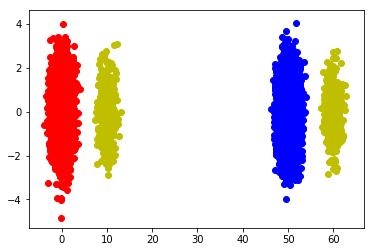

In [1]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random

tf.reset_default_graph()
tf.set_random_seed(1)

# Training Params
num_steps = 100000
learning_rate = 0.00002
x_dim = 2
noise_dim = 20
NUM_LABEL = 1
GAN_CLASS_COE = 500
gan_batch_size = 1000

# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.), dtype=tf.float32)
 
# Linear Regression 
class Generator(object):
  # G Parameters
  def __init__(self, noise_dim, NUM_LABEL, batch_size):
    self.batch_size = batch_size
    self.linear_w1 = tf.Variable(glorot_init([noise_dim+NUM_LABEL, 100]),name='glw1')
    self.linear_b1 = tf.Variable(glorot_init([100]),name='glb1')
    self.linear_w2 = tf.Variable(glorot_init([100, 50]),name='glw2')
    self.linear_b2 = tf.Variable(glorot_init([50]),name='glb2')
    self.linear_w3 = tf.Variable(glorot_init([50, x_dim]),name='glw3')
    self.linear_b3 = tf.Variable(glorot_init([x_dim]),name='glb3')
    
    self.training = True

 # Build G Graph
  def __call__(self, z,y):
    z_y = tf.concat((z,y),1)
    linear_z1 = tf.nn.leaky_relu(tf.matmul(z_y,self.linear_w1) + self.linear_b1)
    linear_z2 = tf.nn.leaky_relu(tf.matmul(linear_z1,self.linear_w2) + self.linear_b2)
    out_layer = tf.matmul(linear_z2,self.linear_w3)+self.linear_b3
    return out_layer

# Logistic Regression
class Disciminator(object):
  # D Parameters
  def __init__(self):
    self.linear_w1 = tf.Variable(glorot_init([x_dim + NUM_LABEL, 100]))
    self.linear_b1 = tf.Variable(glorot_init([100]))
    self.linear_w2 = tf.Variable(glorot_init([100, 1]))
    self.linear_b2 = tf.Variable(glorot_init([1]))

    self.training = True

  # Build D Graph
  def __call__(self, x, y):
    x_y = tf.concat((x,y),1)
    linear1 = tf.nn.relu(tf.matmul(x_y, self.linear_w1) + self.linear_b1)
    out = tf.matmul(linear1, self.linear_w2) + self.linear_b2
    out = tf.sigmoid(out)
    return out

class Classifier(object):
  def __init__(self):
    self.linear_w1 = tf.Variable(glorot_init([x_dim, 100]))
    self.linear_b1 = tf.Variable(glorot_init([100]))
    self.linear_w2 = tf.Variable(glorot_init([100, NUM_LABEL]))
    self.linear_b2 = tf.Variable(glorot_init([NUM_LABEL]))

    self.training = True

  # Build D Graph
  def __call__(self, x):
    linear1 = tf.nn.leaky_relu(tf.matmul(x, self.linear_w1) + self.linear_b1)
    out = tf.matmul(linear1, self.linear_w2) + self.linear_b2
    out = tf.sigmoid(out)
    return out
  
  
def plot_gan_image(name, epoch, sess):
  # Generate images from noise, using the generator network.
  fig, ax = plt.subplots()
  for i in range(2):
#   i = 0    
    # Desired label
    d_label = np.zeros([gan_batch_size, NUM_LABEL])
    d_label[:] = i
    # Noise input.
    z = np.random.uniform(-1., 1., size=[gan_batch_size, noise_dim])
    g = sess.run([gen_sample], feed_dict={gen_input: z, desired_label: d_label})
    g = np.reshape(g, [gan_batch_size,2])
    if i == 0:
      ax.scatter(g[:,0], g[:,1], c='r')
    if i == 1:
      ax.scatter(g[:,0], g[:,1], c='b')
     
  # f.show()
  plt.savefig(name+epoch)

# Build Dataset
features = tf.placeholder(tf.float32, shape=[None, x_dim])
labels = tf.placeholder(tf.float32, shape=[None, NUM_LABEL])
batch_size = tf.placeholder(tf.int64)
sample_size = tf.placeholder(tf.int64)
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.shuffle(sample_size, reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
iter = dataset.make_initializable_iterator()
next_batch = iter.get_next()

mu1 = [0., 0.]
sigma1 = [[1., 0.], [0., 1.]]
mu2 = [50., 0.]
sigma2 = [[1., 0.], [0., 1.]]
x_1 = np.random.multivariate_normal(mu1, sigma1, 10000)
x_2 = np.random.multivariate_normal(mu2, sigma2, 10000)
plt.scatter(x_1[:,0], x_1[:,1], c='r')
plt.scatter(x_2[:,0], x_2[:,1], c='b')
y_1 = np.zeros(10000)
y_2 = np.ones(10000)
x_train = np.concatenate((x_1, x_2), axis=0)
y_train = np.concatenate((y_1, y_2), axis=0)
y_train= y_train.reshape([20000, 1])

#aux_data is same as data1
mu3 = [10., 0.]
mu4 = [60., 0.]

aux_data1 = np.random.multivariate_normal(mu3, sigma1, 500)
aux_data2 = np.random.multivariate_normal(mu4, sigma1, 500)
aux_data = np.concatenate((aux_data1, aux_data2), axis=0)
# random.shuffle(aux_data)
plt.scatter(aux_data[:,0], aux_data[:,1], c='y')

# plt.close()

# Build The Classifier
x = tf.placeholder(tf.float32, shape=[None, x_dim])
y = tf.placeholder(tf.float32, shape=[None, NUM_LABEL])
model = Classifier()
y_ml = model(x)
model_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_ml))

y_pred = tf.math.greater(y_ml, 0.5)
correct = tf.equal(tf.math.greater(y_ml, 0.5), tf.math.greater(y, 0.5))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

model_optimizer = tf.train.AdamOptimizer(0.001).minimize(model_loss, var_list=[model.linear_w1, model.linear_b1, model.linear_w2, model.linear_b2])

# Build Networks
# Network Inputs
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
aux_x = tf.placeholder(tf.float32, shape=[None, x_dim])
aux_label = model(aux_x)
desired_label = tf.where(tf.greater(aux_label, 0.5), tf.ones([gan_batch_size, 1]), tf.zeros([gan_batch_size, 1]))

# Build G Network
G = Generator(noise_dim, NUM_LABEL, gan_batch_size)
gen_sample = G(gen_input,desired_label)
gen_label =  model(gen_sample)

# Build 2 D Networks (one from noise input, one from generated samples)
D = Disciminator()
disc_real = D(aux_x, desired_label)
disc_fake = D(gen_sample, desired_label)

# Build Loss
gan_class_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=desired_label, logits=gen_label))
gen_loss = -tf.reduce_mean(tf.log(tf.minimum(0.01, disc_fake))) + GAN_CLASS_COE*gan_class_loss
disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake))

# gen_loss = -tf.reduce_mean(disc_fake) + GAN_CLASS_COE*gan_class_loss
# disc_loss = -tf.reduce_mean(disc_real) + tf.reduce_mean(disc_fake) 

# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)

# G Network Variables
gen_vars = [G.linear_w1, G.linear_b1, G.linear_w2, G.linear_b2, G.linear_w3, G.linear_b3]
# D Network Variables
disc_vars = [D.linear_w1, D.linear_b1, D.linear_w2, D.linear_b2]

# Create training operations
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)


Epoch 0, training accuracy 0.607
Epoch 1000, training accuracy 1
test acc: 1.0
cluster1:  (10000, 2) cluster2:  (10000, 2)
Epoch 0: Generator Loss: 4.605165, Discriminator Loss: 0.290808
Epoch 2000: Generator Loss: 4.605169, Discriminator Loss: 0.019970
Epoch 4000: Generator Loss: 4.606632, Discriminator Loss: 0.015236
Epoch 6000: Generator Loss: 4.607599, Discriminator Loss: 0.014125
Epoch 8000: Generator Loss: 4.610019, Discriminator Loss: 0.055167
Epoch 10000: Generator Loss: 4.624762, Discriminator Loss: 0.111908
Epoch 12000: Generator Loss: 4.630304, Discriminator Loss: 0.121488
Epoch 14000: Generator Loss: 4.619628, Discriminator Loss: 0.108021
Epoch 16000: Generator Loss: 4.611617, Discriminator Loss: 0.096542
Epoch 18000: Generator Loss: 4.606183, Discriminator Loss: 0.080331
Epoch 20000: Generator Loss: 4.608695, Discriminator Loss: 0.062510
Epoch 22000: Generator Loss: 4.609234, Discriminator Loss: 0.057446
Epoch 24000: Generator Loss: 4.608517, Discriminator Loss: 0.079201
E

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 40000: Generator Loss: 4.609627, Discriminator Loss: 0.169631
Epoch 42000: Generator Loss: 4.609633, Discriminator Loss: 0.234195
Epoch 44000: Generator Loss: 4.607481, Discriminator Loss: 0.290460
Epoch 46000: Generator Loss: 4.606851, Discriminator Loss: 0.347834
Epoch 48000: Generator Loss: 4.607015, Discriminator Loss: 0.406452
Epoch 50000: Generator Loss: 4.607194, Discriminator Loss: 0.458958
Epoch 52000: Generator Loss: 4.606505, Discriminator Loss: 0.518587
Epoch 54000: Generator Loss: 4.605539, Discriminator Loss: 0.555798
Epoch 56000: Generator Loss: 4.605437, Discriminator Loss: 0.604779
Epoch 58000: Generator Loss: 4.605426, Discriminator Loss: 0.607297
Epoch 60000: Generator Loss: 4.605443, Discriminator Loss: 0.641177
Epoch 62000: Generator Loss: 4.605306, Discriminator Loss: 0.639080
Epoch 64000: Generator Loss: 4.605634, Discriminator Loss: 0.642796
Epoch 66000: Generator Loss: 4.605260, Discriminator Loss: 0.626112
Epoch 68000: Generator Loss: 4.605182, Discrimin

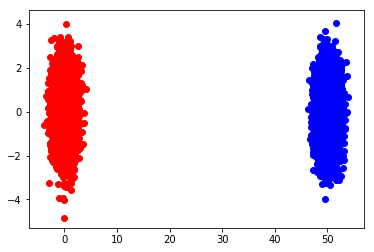

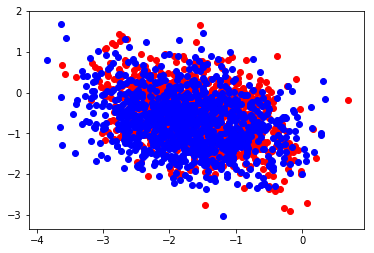

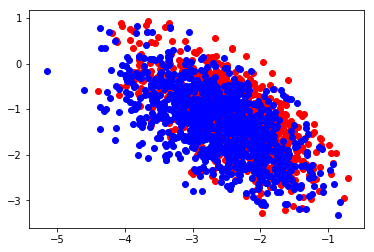

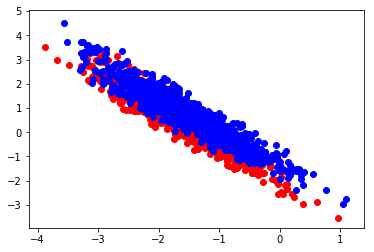

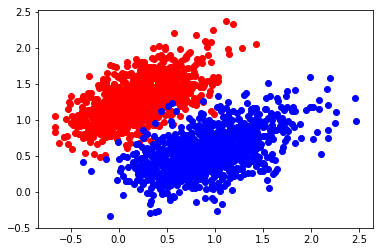

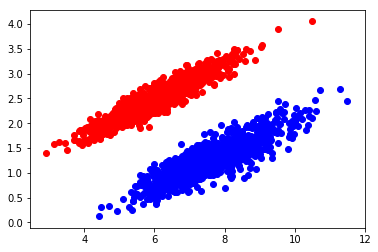

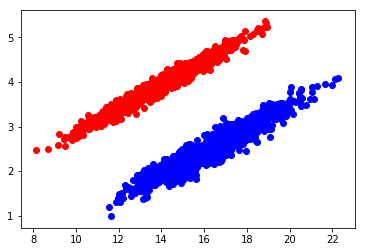

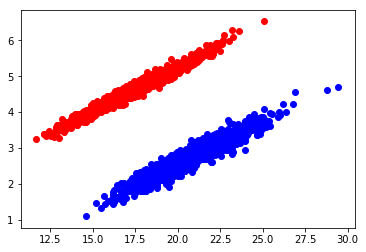

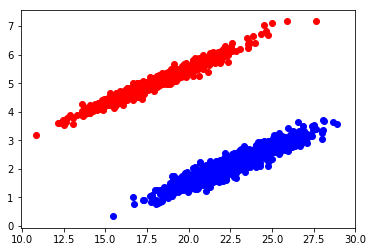

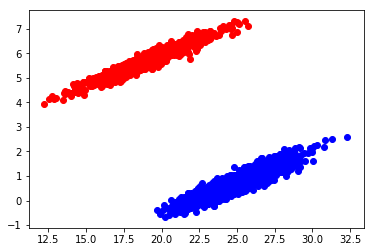

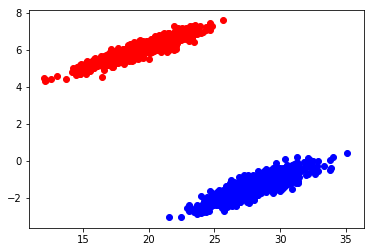

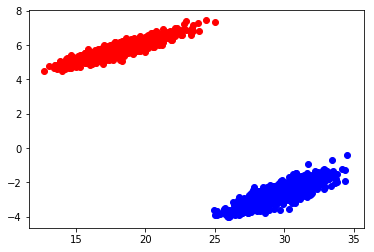

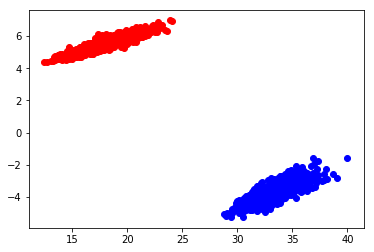

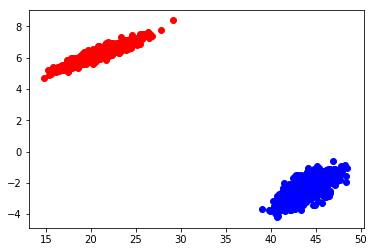

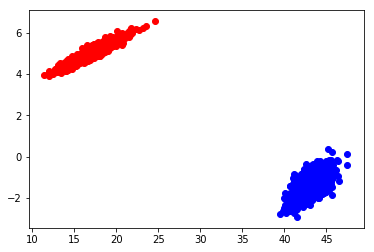

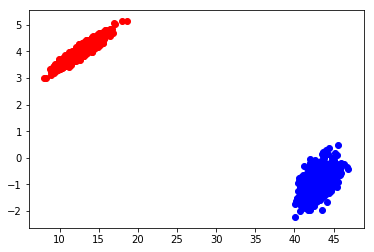

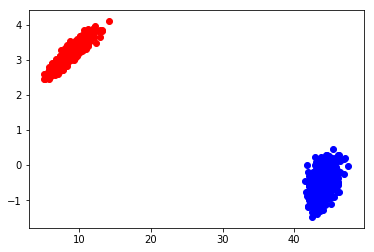

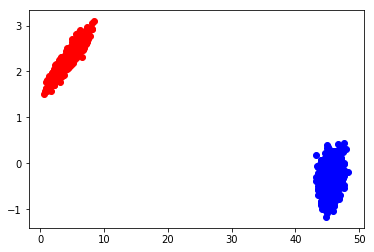

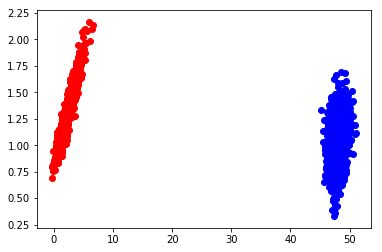

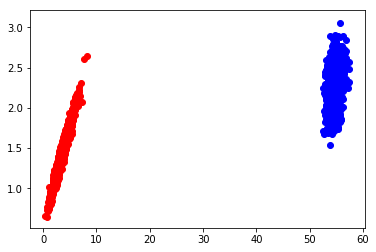

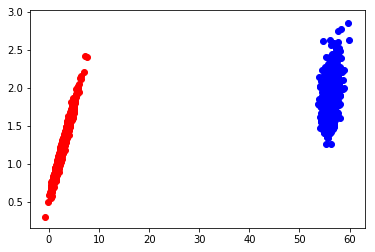

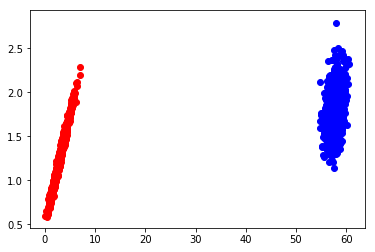

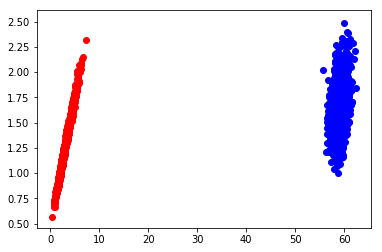

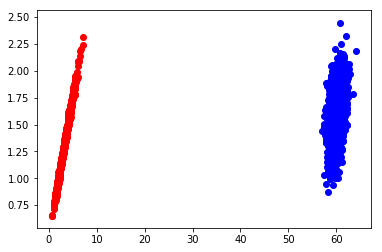

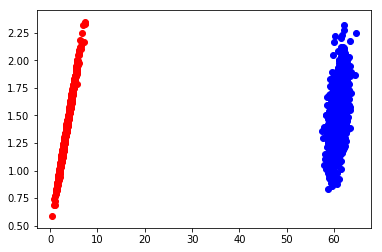

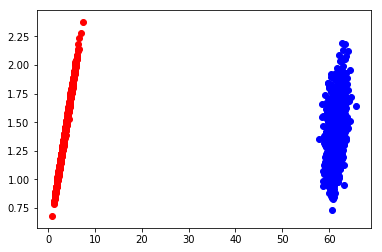

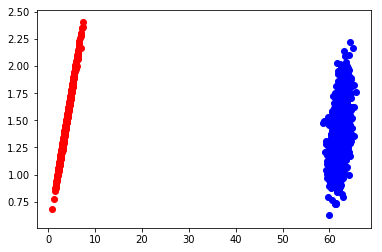

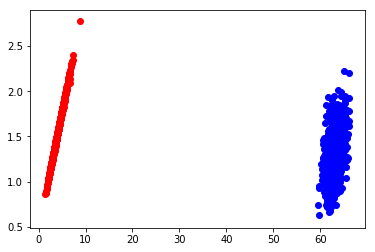

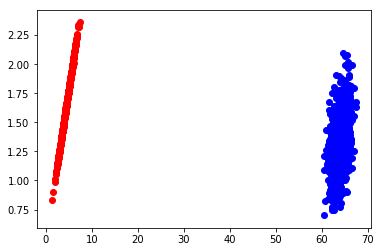

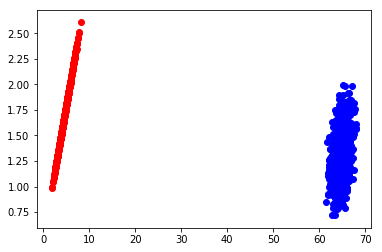

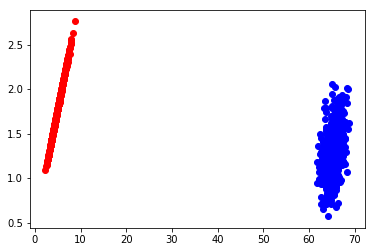

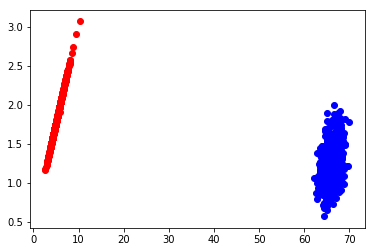

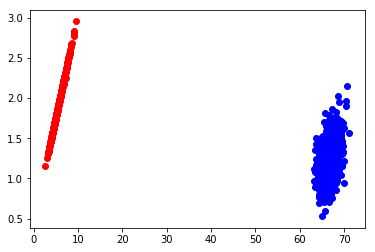

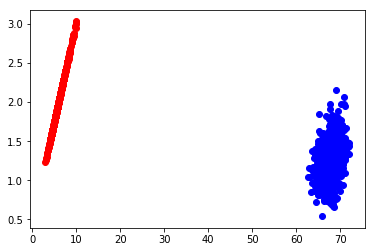

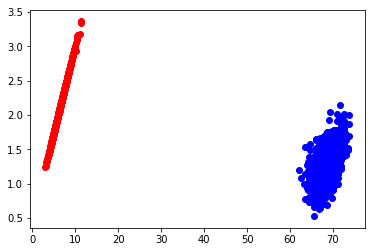

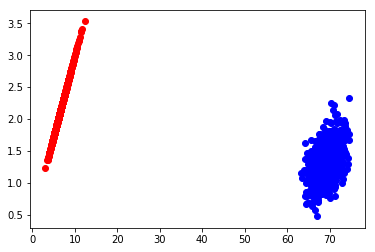

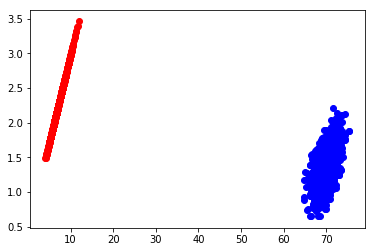

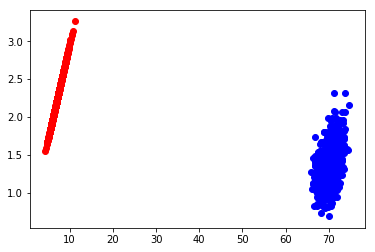

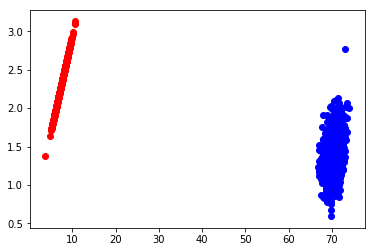

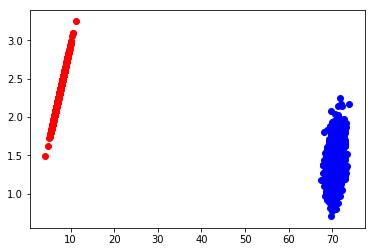

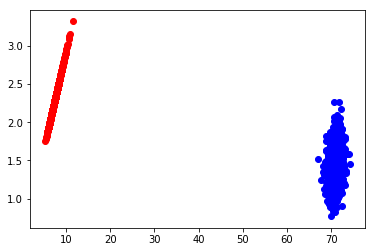

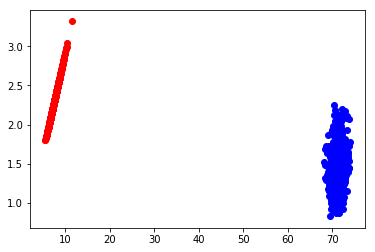

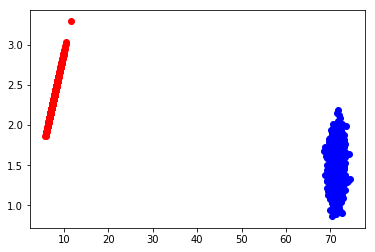

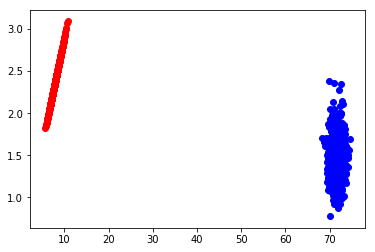

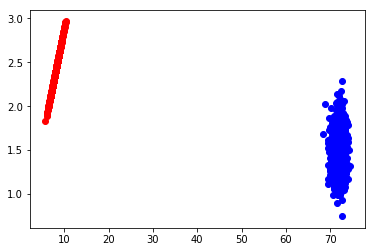

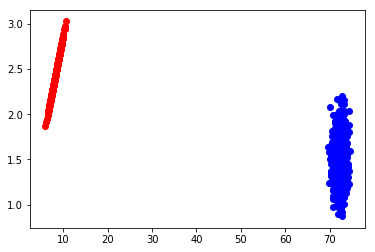

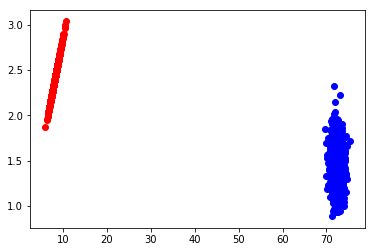

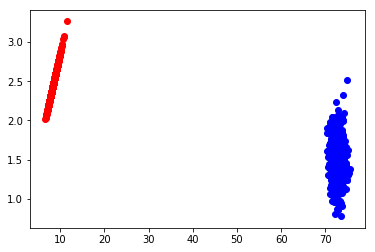

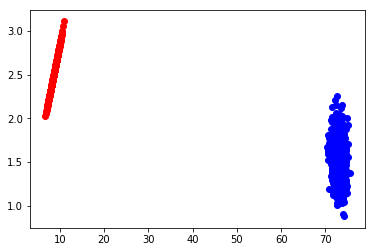

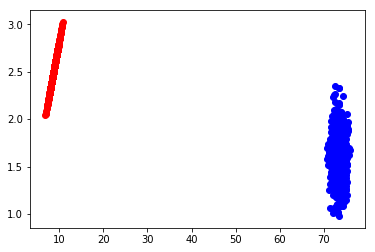

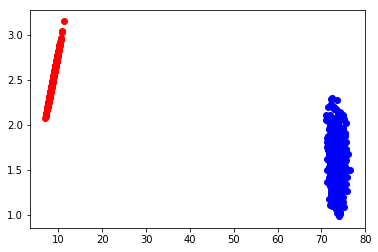

In [2]:
def train_gan():
  # Train Classifier
  
  # Initialize the variables (i.e. assign their default value)
  init = tf.global_variables_initializer()

  # Start training
  with tf.Session() as sess:

      # Run the initializer
      sess.run(init)

      sess.run(iter.initializer, feed_dict = {features: x_train, labels: y_train, batch_size: gan_batch_size, sample_size: 25000})

      # Train the Classifier First
      for i in range(2000):
        batch = sess.run(next_batch)
        model_optimizer.run(feed_dict={ x: batch[0], y: batch[1]})
        if i % 1000 == 0:
          train_accuracy = accuracy.eval(feed_dict={x: batch[0], y: batch[1] })
          print('Epoch %d, training accuracy %g' % (i, train_accuracy))    

      test_acc, y_prediction = sess.run([accuracy, y_pred], feed_dict={x: x_train, y: y_train})
      print("test acc:", test_acc)

      cluster1 = []
      cluster2 = []
      for i in range(0, 20000):
        if y_prediction[i]:
          cluster2.append(x_train[i])
        else:
          cluster1.append(x_train[i])

      cluster1 = np.array(cluster1)
      cluster2 = np.array(cluster2)
      print('cluster1: ', cluster1.shape, 'cluster2: ', cluster2.shape)
      plt.scatter(cluster1[:,0], cluster1[:,1],c='r')
      plt.scatter(cluster2[:,0], cluster2[:,1],c='b')
      plt.savefig('Classifier_plot')
      
      #Train GAN
      for i in range(100000):
        batch_x = aux_data
        
        # Sample random noise 
        z = np.random.uniform(-1., 1., size=[gan_batch_size, noise_dim])
       
        #! Train Discriminator
        train_disc.run(feed_dict={aux_x: batch_x,  gen_input: z})
#         if i % 5 == 0:
        train_gen.run(feed_dict={aux_x: batch_x,  gen_input: z})
       
        if i % 2000 == 0:
          gl,dl = sess.run([gen_loss, disc_loss], feed_dict={aux_x: batch_x,  gen_input: z})
          print('Epoch %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
          plot_gan_image('gan_out',str(i), sess)
      
      
if __name__ == '__main__':
  train_gan()